In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib

from ATARI.sammy_interface import sammy_classes, sammy_functions

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy

import ATARI.utils.plotting as myplot


In [2]:
sammypath = ''
assert(sammypath != '')

In [3]:
%matplotlib widget

# 1, 2 mm Capture Yield Data


In [4]:
# energy_range_Y = (310, 400) #
energy_range_Y = [0.15e3, 100e3] #200e3]

### 1mm capture data
capdat1 = sammy_functions.readlst(os.path.realpath("./data/yield_ta1b_unsmooth.dat"))
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_Y,
                                energy_grid = capdat1.E.values, #np.sort(capdat1.E.values),
                                template = os.path.realpath(f'./data/template_cap1mm_edited'),
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )

capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]

### 2mm capture data
capdat2 = sammy_functions.readlst(os.path.realpath("./data/yield_ta2_unsmooth.dat"))
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_Y,
                                energy_grid = np.sort(capdat2.E.values),
                                template = os.path.realpath(f'./data/template_cap2mm_edited'),
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]

### setup in zipped lists 
datasets = [capdat1, capdat2]
experiments= [expcap1, expcap2]
covariance_data = [{}, {}]


### Approximate the resonances that generated this data

Synthetic data can be generated around any point-wise vector (of the experimental object transmission or capture yield) that is taken as 'true'.
In order to better compare synthetic data to real data, we must approximate the resonance structures that generated the real data and use those as 'true'
For this, you can take the evaluated JEFF parameters or fit the new data from those parameters.
Because we have multiple datasets, the sammy_YW scheme can be used to fit all 3 simultaneously.

In [5]:
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })

matnum = 7328
jeff_file = os.path.realpath("./data/73-Ta-181g.jeff33")
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, rto)

jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_Y)) & (jeff_parameters.E>min(energy_range_Y))]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))


### setup the reaction model - Ta-181 is the default
Ta_pair = Particle_Pair()      

sammyINPyw = sammy_classes.SammyInputDataYW(
    Ta_pair,
    resonance_ladder=jeff_parameters,

    datasets = datasets ,
    experiments= experiments,
    experimental_covariance = covariance_data,

    max_steps = 1,
    iterations = 1,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = False,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 1
)

sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)
print(sammyOUT.chi2)
print(sammyOUT.chi2_post)

[51313.2, 109013.0]
None


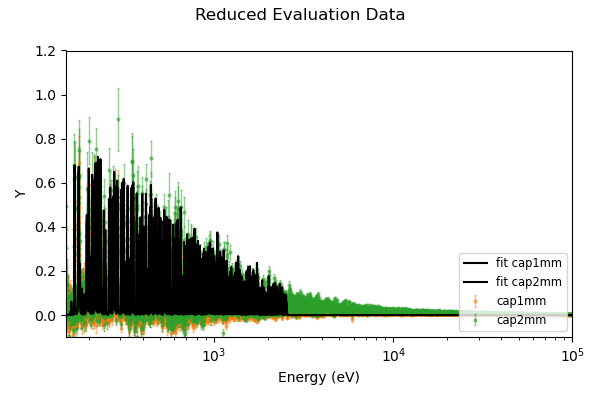

In [8]:

importlib.reload(myplot)

fig = myplot.plot_reduced_data_Y(datasets, experiments,
                                 fits=sammyOUT.pw_post,
                               xlim=energy_range_Y)#200e3))
fig.suptitle("Reduced Evaluation Data")
fig.tight_layout()

## Approximating the measurement model


Similar to the 1, 3, and 6 mm transmission data, we do not have access to any of the raw data used for capture measurements.
For capture, the most challenging aspect of approximating the measurement model will be background and incident flux measurements (open spectrum).
These measurements are much more complex than transmission for several reasons; 
1) the shape of the incident flux spectrum is much more important, whereas in transmission the shape is assumed to cancel out in-ratio and only the magnitude/normalization matters.
2) The cascade detection efficiency and pulse-height weighting method introduce many complexities, assumptions, and potential (unquantified) correlations (between cascade and detection probability).
3) The background does not take a functional form, rather point-wise time-of-flight measurements are used directly.

The current state of synthetic capture yield data is not at full fidelity.

Item 1 above is partially addressed by using the Li6-detector neutron spectrum that we have access to (thanks to Jesse Brown) as the flux measurement. 
Consequently, that spectrum must be normalized to Li6 yield. 
The actual measurements were done using a B4C sample and therefore normalized to B4C yield.
The importance of the flux shape in capture yield measurements means that we cannot use a crude approximation to the B4C-detector flux. 
However, if we assume 
a) that the flux spectrum is the same (same target and linac settings) and 
b) the yield normalizations for both Li6 and B4C are exactly correct, 
then the flux spectra calculated by yield-normalized Li6 and B4C spectra should be the same.
In this case, the only difference in the resulting data should be the shape/magnitude of the uncertainty if b is not true and uncertainty in the yield normalization is propagated.
Of course, assumption a is not correct either as the Li-6 spectrum we have access to uses a different target and flight path.
Nonetheless, using the real Li-6 spectrum is still preferred to a crude approximation of the B4C spectrum.
We can suppose that our model, then, is of higher fidelity but representative of a different set of capture measurements done with the same target and flight path as the 12mm transmission measurements.

Items 2 and 3 are not addressed in the current methodology. 
For 2, the generative modelling will not go deeper than sampling uncertainty on the cascade detection efficiency parameter.
Higher fidelity here might mean introducing correlations between cascade efficiency and multiplicity or gamma energy.
For 3, crude approximations of gamma backgrounds measurements are taken.

Despite these shortcomings, we can create medium-utility capture data with a similar noise/covariance structure by guess-and-check of the parameters.

In [22]:
from ATARI.syndat import syndat_model
importlib.reload(syndat_model)
from copy import deepcopy
from ATARI.ModelData.measurement_models import capture_yield_rpi
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT, Syndat_Control
importlib.reload(capture_yield_rpi)


pars_1mm = {
    "trig_g"    : (0.25e7,  0),
    "trig_bg"   : (0.1e7,  0),
    "trig_f"    : (0.25e7,    0),
    "trig_bf"   : (0.1e7,  0),
    "fn"        : (1.0,      0.03842),
    "background_spectrum_bg"        : None,
    "incident_neutron_spectrum_f"   : None,
    "background_spectrum_bf"        : None,
}
cap1mm_gen_meas = capture_yield_rpi.Capture_Yield_RPI(**pars_1mm)
cap1mm_red_meas = capture_yield_rpi.Capture_Yield_RPI(**pars_1mm)

pars_2mm = {
    "trig_g"    : (0.25e7,  0),
    "trig_bg"   : (0.1e7,  0),
    "trig_f"    : (0.25e7,    0),
    "trig_bf"   : (0.1e7,  0),
    "fn"        : (1.0,      0.03842),
    "background_spectrum_bg"        : None,
    "incident_neutron_spectrum_f"   : None,
    "background_spectrum_bf"        : None,
}
cap2mm_gen_meas = capture_yield_rpi.Capture_Yield_RPI(**pars_2mm)
cap2mm_red_meas = capture_yield_rpi.Capture_Yield_RPI(**pars_2mm)

## approximate unknown data (spectra with defaults)
for measurement_model in [cap1mm_gen_meas, cap1mm_red_meas]:
    measurement_model.approximate_unknown_data(exp_model=expcap1, smooth=False, check_trig=True,nominal=35)

for measurement_model in [cap2mm_gen_meas, cap2mm_red_meas]:
    measurement_model.approximate_unknown_data(exp_model=expcap2, smooth=False, check_trig=True,nominal=35)


### Now generate synthetic data with the approximated measurement parameters

In [23]:
### define syndat options and model, do not sample resonances
synOPT = syndatOPT(sampleRES=False, calculate_covariance=False, explicit_covariance=False, sample_counting_noise=True, sampleTMP=False, )

syndat_cap1mm = Syndat_Model(expcap1,
                            cap1mm_gen_meas,
                            cap1mm_red_meas,
                            options = synOPT,
                            title='cap1mm')
syndat_cap2mm = Syndat_Model(expcap2,
                            cap2mm_gen_meas,
                            cap2mm_red_meas,
                            options = synOPT,
                            title='cap2mm')

### set the resonance ladder for the reaction model
Ta_pair.resonance_ladder = copy(sammyOUT.par_post)

### build syndat control module and draw samples
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models = [syndat_cap1mm, syndat_cap2mm],
                        model_correlations = [],
                        sampleRES = False,
                        save_raw_data=True
                        )

# pass pw true instead of recalculating model bc it is expensive ofer this energy range
pw_true_list = deepcopy(sammyOUT.pw_post)
[df.rename(columns={"theo_xs":'true'}, inplace=True) for df in pw_true_list]


rto.bayes = False
syndat.sample(rto, num_samples=1, pw_true_list=pw_true_list)

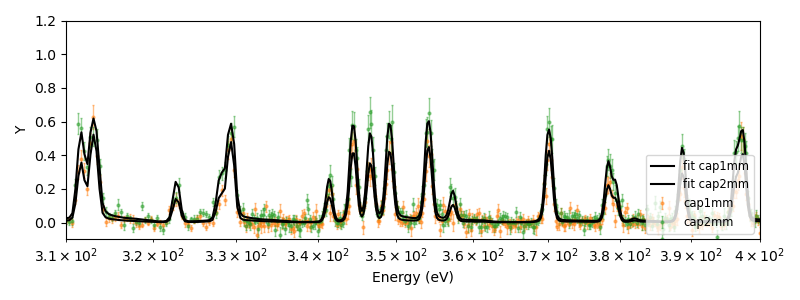

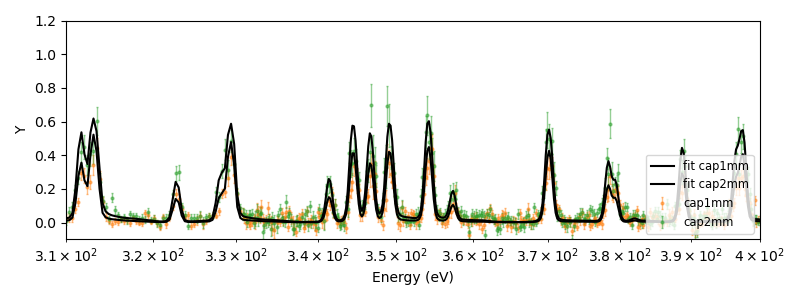

In [24]:
sample1 = syndat.get_sample(0)

syndat_datasets = [out.pw_reduced for key, out in sample1.items()]
fig_synthetic = myplot.plot_reduced_data_Y(syndat_datasets[:], experiments[:],
                                        xlim=(310, 400),#energy_range_T, #(.15e3, 2.5e3),
                                    fig_size=(8,3),
                                    fits=sammyOUT.pw_post)

fig_trans_real = myplot.plot_reduced_data_Y(datasets[:], experiments[:],
                                 xlim=(310, 400),#energy_range_T
                               fig_size=(8,3),
                               fits=sammyOUT.pw_post)

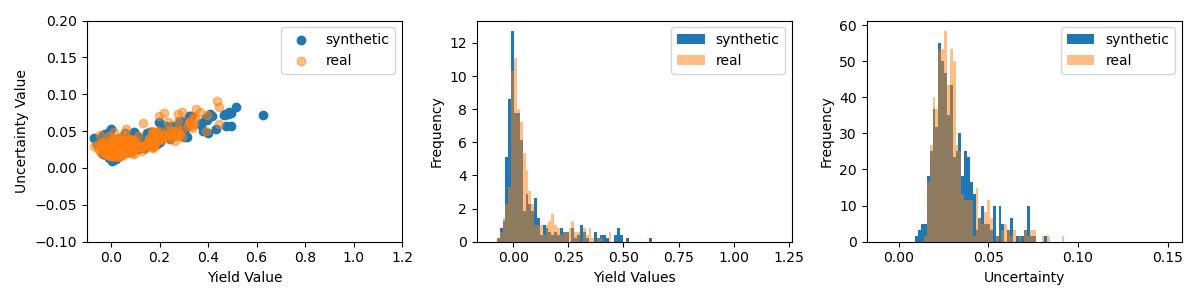

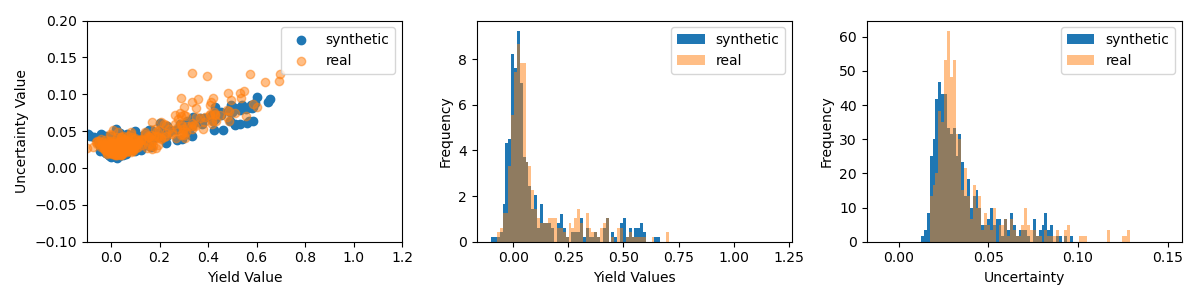

In [25]:

mask_syndat = (syndat_datasets[0].E>310.0) & (syndat_datasets[0].E<400)
mask_real= (datasets[0].E>310.0) & (datasets[0].E<400)

for syn, real in zip(syndat_datasets, datasets):
# syn = syndat_datasets[0]
# real = datasets[0]

    synthetic_data = syn[mask_syndat]
    real_data = real[mask_real]


    fig, axes = subplots(1,3, figsize=(12,3))

    axes[0].scatter(synthetic_data.exp, synthetic_data.exp_unc, label='synthetic')
    axes[0].scatter(real_data.exp, real_data.exp_unc, label='real', alpha=0.5)
    axes[0].set_xlim([-0.1,1.2])
    axes[0].set_ylim([-0.1, 0.2])
    axes[0].set_ylabel("Uncertainty Value")
    axes[0].set_xlabel("Yield Value")

    bins = 100
    # range = (-4,4)
    # _ = axes[1].hist((synthetic_data.exp-synthetic_data.true)/synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic') #-red_data.true
    # _ = axes[1].hist((real_data.exp-synthetic_data.true)/real_data.exp_unc, bins=bins, range=range, alpha=0.5,density=True, label='real')#-red_data.true
    # axes[1].set_xlabel("Residuals")
    range = (-0.1, 1.2)
    _ = axes[1].hist((synthetic_data.exp), bins=bins, range=range, density=True,label='synthetic')  #-red_data.true
    _ = axes[1].hist((real_data.exp), bins=bins, range=range, alpha=0.5,density=True, label='real') #-red_data.true
    axes[1].set_xlabel("Yield Values")
    axes[1].set_ylabel("Frequency")


    bins = 100
    range = (-.01,.15)
    _ = axes[2].hist(synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic')
    _ = axes[2].hist(real_data.exp_unc, bins=bins, range=range, alpha=0.5, density=True,label='real')
    axes[2].set_xlabel("Uncertainty")
    axes[2].set_ylabel("Frequency")

    for ax in axes:
        ax.legend()

    # fig.suptitle("")
    fig.tight_layout()

# Saving the Syndat model
The syndat_model and syndat_control objects can be saved using pickle.
All parameters and settings will follow such that the model can be loaded and immediately sampled from.
If saving the syndat_model objects, samples generated using syndat_control must be cleared.
This is the preferred method for this notebook because these syndat models are going to be compiled and sampled from elsewhere (in GenerateData_Ta181.ipynb).
Alternatively, you can save the control object.
This will allow all of the samples to also be saved in the pkl.

In [26]:
from ATARI.utils import atario
importlib.reload(atario)

# ### saving is commented out because the models have already been generated and saved
# atario.save_syndat_model(syndat_cap1mm, os.path.join(os.getcwd(), "results", "SyndatModel_1mmY.pkl"), clear_samples=True)
# atario.save_syndat_model(syndat_cap2mm, os.path.join(os.getcwd(), "results", "SyndatModel_2mmY.pkl"), clear_samples=True)
